In [144]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import pylab as pl
from sklearn.metrics.cluster import adjusted_rand_score
%matplotlib inline

## Read in Data

In [62]:
data = pd.read_csv('FMADatasetTrans-cleaned.csv').drop('Unnamed: 0',axis=1)
response = pd.Series.from_csv('response.csv')

C:\Users\prern\Anaconda3\lib\site-packages\pandas\core\series.py:3724: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


In [63]:
response.value_counts()

Rock                   1997
Experimental           1344
Electronic             1258
Hip-Hop                 369
Folk                    339
Pop                     325
International           237
Classical               234
Instrumental            169
Spoken                  118
Old-Time / Historic      95
Jazz                     93
Soul-RnB                 39
Country                  32
Blues                    29
Easy Listening            4
dtype: int64

In [64]:
data['genre'] = response
data=data.loc[data['genre']!='Easy Listening'].reset_index(drop=True)
response = data['genre'].copy(deep=True)
data=data.drop('genre',axis=1)
response

0             Hip-Hop
1                 Pop
2                Rock
3                Rock
4                Rock
5                Rock
6                Rock
7                Rock
8                Rock
9                Rock
10               Rock
11               Rock
12               Rock
13               Rock
14               Rock
15               Rock
16               Rock
17               Rock
18               Rock
19               Rock
20               Rock
21               Rock
22               Rock
23               Rock
24               Rock
25               Rock
26               Rock
27               Rock
28         Electronic
29         Electronic
            ...      
6648     Experimental
6649     Experimental
6650     Experimental
6651     Experimental
6652     Experimental
6653     Experimental
6654     Experimental
6655     Experimental
6656     Experimental
6657       Electronic
6658       Electronic
6659    International
6660    International
6661    International
6662    In

In [65]:
le = LabelEncoder() #encode variables so that they can be put into a model
responseEncoded = le.fit_transform(response)
responseEncoded

array([ 6, 11, 12, ...,  5,  5,  5], dtype=int64)

## Visualizing Dataset in 2D

In [66]:
def plotClasses2D(X,y,dimensionality_reduction='PCA',title=None):
    '''
    Use this to visualize the separation of classes in two dimensions.'''
    if dimensionality_reduction=='PCA':
        pca = PCA(n_components=2) #two dimensions to plot on two dimensions
        xPlot = pca.fit_transform(X)
    elif dimensionality_reduction=='TSNE':
        tsne = TSNE(n_components=2)
        xPlot = tsne.fit_transform(X)
    else:
        xPlot=X
    df = pd.DataFrame(xPlot)
    if len(df.columns)!=2:
        return "DimError: Can't plot data not in two dimensions"
    df['y'] = y
    plt.figure()
    for label in df['y'].unique():
        sns.regplot(df[0].loc[df['y']==label],df[1].loc[df['y']==label],fit_reg=False,label=label)
        plt.legend(bbox_to_anchor=(1.1,1.05))
        if title!=None:
            plt.title(title)

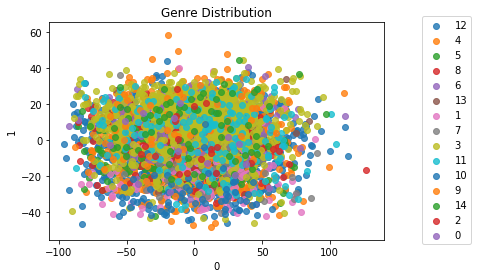

In [67]:
plotClasses2D(X_train,y_train,title='Genre Distribution') #pca

## Gaussian Mixture Models

## I. Data before PCA

In [68]:
data.head()

,acousticness,danceability,energy,instrumentalness,speechiness,tempo,valence,artist_discovery,artist_familiarity,artist_hotttnesss,...,tonnetz.37,tonnetz.38,tonnetz.39,tonnetz.40,tonnetz.41,zcr,zcr.1,zcr.2,zcr.3,zcr.6
0,-0.695041,0.682179,0.634544,-1.215102,-2.468293,0.642706,0.575714,0.582495,0.471984,0.508989,...,-1.918384,-1.046551,-1.561353,-1.755760,-1.530469,-8.973411,0.354692,-1.950820,-2.151796,-1.723735
1,-0.760227,0.521350,0.817554,-1.239133,-0.839564,0.479206,0.267598,0.582495,0.471984,0.508989,...,-1.408139,-1.020470,-1.145736,-1.475555,-1.571847,-6.368528,0.434410,-1.681186,-1.761941,-1.803182
2,-0.043759,0.662830,0.924633,-0.030882,-8.062676,0.414608,0.963518,0.834591,0.749667,1.000000,...,-1.734801,-1.081774,-0.893442,-1.532135,-1.298345,-13.384400,0.209889,-1.981206,-2.011986,-2.208358
3,-0.642571,0.504525,0.560467,-1.194809,-0.678925,0.426055,0.893843,0.582495,0.471984,0.508989,...,-1.299278,-0.527856,-0.971555,-1.192269,-1.172752,-5.568277,0.266398,-2.469772,-2.578564,-2.500909
4,-1.301601,0.228931,0.607130,-0.164302,-8.809239,0.772947,0.158379,0.582395,0.403694,0.508901,...,-1.661267,-1.367831,-1.443515,-1.800587,-1.600945,-6.299742,0.330474,-2.112630,-2.159863,-2.296970


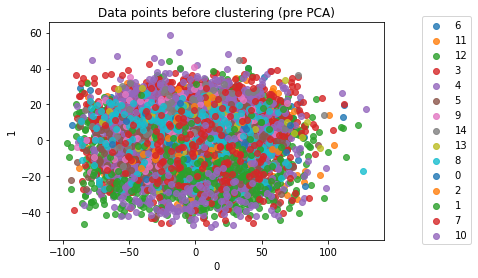

In [69]:
# How our data looks before clustering
plotClasses2D(data,responseEncoded,dimensionality_reduction='PCA',title='Data points before clustering (pre PCA)')

## Finding optimal number of clusters:
## (a) AIC and BIC criterion
Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a given set of data. Lower value of AIC suggests "better" model, but it is a relative measure of model fit.
Bayesian information criterion (BIC) is a criterion for model selection among a finite set of models; the model with the lowest BIC is preferred

Text(0.5,1,'AIC and BIC function')

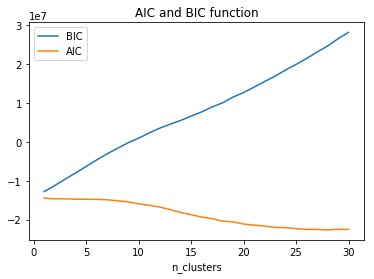

In [70]:
n_clusters = np.arange(1, 31)
models = [GaussianMixture(k, covariance_type='full', random_state=0).fit(data)
          for k in n_clusters]

plt.plot(n_clusters, [m.bic(data) for m in models], label='BIC')
plt.plot(n_clusters, [m.aic(data) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_clusters');
plt.title('AIC and BIC function')

In order to choose a model, we can use either AIC or BIC metric. The optimal number of clusters is the value that minimizes the AIC or BIC. We get a reasonable value for n_clusters (number of clusters) with BIC. The lowest value of BIC is n=3 after which the function steadily increases. The lowest value for AIC is 30 but using this metric can lead to overfitting

## (b) Silhouette Score metric
The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.


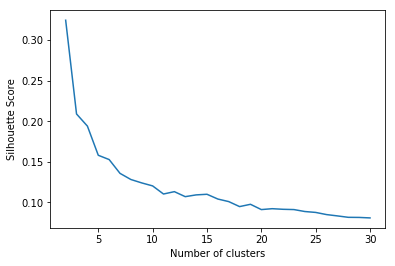

In [71]:
def sc_evaluate_clusters(X,max_clusters):
    s = np.zeros(max_clusters+1)
    s[0] = 0;
    s[1] = 0;
    for k in range(2,max_clusters+1):
        gmm = GaussianMixture(n_components=k,random_state=0).fit(data)
        preds = gmm.predict(data)
        s[k] = silhouette_score(X,preds,metric='euclidean')
    plt.plot(range(2,len(s)),s[2:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    
sc_evaluate_clusters(data,30)

We can see the second maxima i.e highest silhouette score value is when number of clusters is 12.

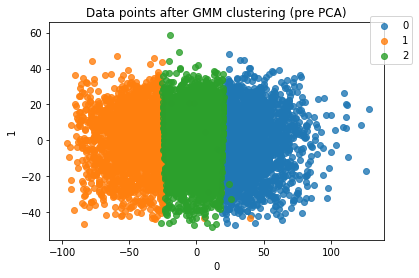

In [153]:
gmm = GaussianMixture(n_components=3,random_state=0).fit(data)
prediction = gmm.predict(data)
plotClasses2D(data,prediction,dimensionality_reduction='PCA',title='Data points after GMM clustering (pre PCA)')

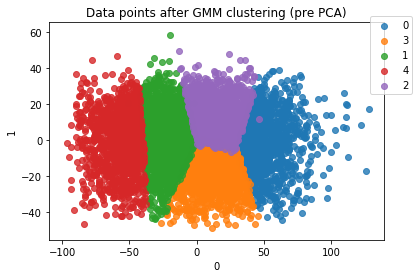

In [152]:
gmm = GaussianMixture(n_components=5,random_state=0).fit(data)
prediction = gmm.predict(data)
plotClasses2D(data,prediction,dimensionality_reduction='PCA',title='Data points after GMM clustering (pre PCA)')

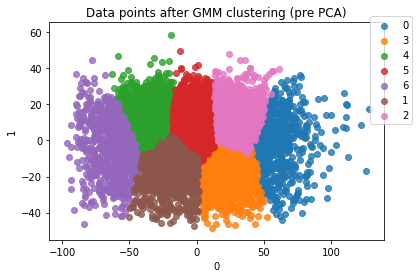

In [151]:
gmm = GaussianMixture(n_components=7,random_state=0).fit(data)
prediction = gmm.predict(data)
plotClasses2D(data,prediction,dimensionality_reduction='PCA',title='Data points after GMM clustering (pre PCA)')

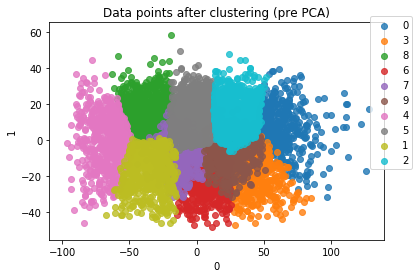

In [156]:
gmm = GaussianMixture(n_components=10,random_state=0).fit(data)
prediction = gmm.predict(data)
plotClasses2D(data,prediction,dimensionality_reduction='PCA',title='Data points after clustering (pre PCA)')

## Comparing perfomance of k-Means and GMM

In [146]:
kmeans = KMeans(init='k-means++',n_clusters=7,n_init=10)
kmeans.fit_predict(data)

array([1, 2, 5, ..., 0, 2, 2])

In [132]:
adjusted_rand_score(kmeans.labels_,prediction)

0.9959327030734206

In [147]:
adjusted_rand_score(responseEncoded,kmeans.labels_)

0.008308063775857459

In [148]:
from sklearn.cluster import KMeans
kmeans = KMeans(init='k-means++',n_clusters=16,n_init=10)
kmeans.fit_predict(data)

array([ 1, 14, 12, ...,  0,  8,  8])

In [149]:
adjusted_rand_score(responseEncoded,kmeans.labels_)

0.014134025651810189

In [150]:
gmm = GaussianMixture(n_components=16,random_state=0).fit(data)
prediction = gmm.predict(data)
adjusted_rand_score(responseEncoded,prediction)

0.016333595679729772

## II. Data after PCA

In [91]:
reducedDf = pd.read_csv('FMADataset-reduced-with-pca.csv')
reducedDf.head()

,Unnamed: 0,0,1,2,3,4,5,6,genre
0,0,60.587093,13.525421,6.449218,10.029388,4.010357,4.867023,2.092142,Hip-Hop
1,1,29.202348,-4.947352,4.182831,25.509447,1.183777,-2.958195,-2.579032,Pop
2,2,-25.704546,12.391144,5.863817,-0.529203,-8.526611,-5.371636,-7.365766,Rock
3,3,16.925889,-26.848047,-7.041860,-3.180312,0.226964,-2.598218,1.994708,Rock
4,4,-2.035927,-0.554280,-16.761623,-7.882677,-0.832575,10.548514,-7.882686,Rock


In [92]:
# dropping unnamed column
reducedDf = reducedDf[['0','1','2','3','4','5','6','genre']]
reducedDf.head()

,0,1,2,3,4,5,6,genre
0,60.587093,13.525421,6.449218,10.029388,4.010357,4.867023,2.092142,Hip-Hop
1,29.202348,-4.947352,4.182831,25.509447,1.183777,-2.958195,-2.579032,Pop
2,-25.704546,12.391144,5.863817,-0.529203,-8.526611,-5.371636,-7.365766,Rock
3,16.925889,-26.848047,-7.041860,-3.180312,0.226964,-2.598218,1.994708,Rock
4,-2.035927,-0.554280,-16.761623,-7.882677,-0.832575,10.548514,-7.882686,Rock


In [93]:
genres = reducedDf['genre'].copy(deep=True)
reducedDf=reducedDf.drop('genre',axis=1)
genres

0             Hip-Hop
1                 Pop
2                Rock
3                Rock
4                Rock
5                Rock
6                Rock
7                Rock
8                Rock
9                Rock
10               Rock
11               Rock
12               Rock
13               Rock
14               Rock
15               Rock
16               Rock
17               Rock
18               Rock
19               Rock
20               Rock
21               Rock
22               Rock
23               Rock
24               Rock
25               Rock
26               Rock
27               Rock
28         Electronic
29         Electronic
            ...      
6652     Experimental
6653     Experimental
6654     Experimental
6655     Experimental
6656     Experimental
6657     Experimental
6658     Experimental
6659     Experimental
6660     Experimental
6661       Electronic
6662       Electronic
6663    International
6664    International
6665    International
6666    In

In [94]:
le1 = LabelEncoder() #encode variables so that they can be put into a model
genresEncoded = le1.fit_transform(genres)
genresEncoded

array([ 7, 12, 13, ...,  6,  6,  6], dtype=int64)

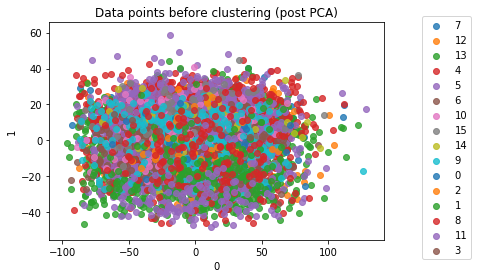

In [95]:
# How our data looks before clustering
plotClasses2D(reducedDf,genresEncoded,dimensionality_reduction='PCA',title='Data points before clustering (post PCA)')

## Finding optimal number of clusters:

## (a) AIC and BIC Criteria

Text(0.5,1,'AIC and BIC function')

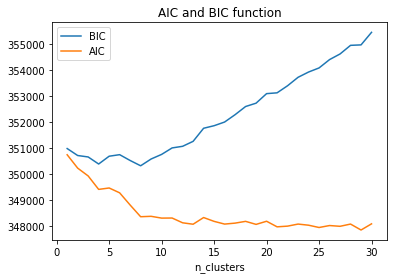

In [96]:
n_clusters = np.arange(1, 31)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(reducedDf)
          for n in n_clusters]

plt.plot(n_clusters, [m.bic(reducedDf) for m in models], label='BIC')
plt.plot(n_clusters, [m.aic(reducedDf) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_clusters');
plt.title('AIC and BIC function')

In order to choose a model, we can use either AIC or BIC metric. The optimal number of clusters is the value that minimizes the AIC or BIC. We get a reasonable value for n_clusters (number of clusters) with BIC, that is when n_clusters=6. AIC shows lowest value at n_clusters=30, but this could lead to overfitting. We can see that at n_clusters=11, AIC reaches a lower value than before and at n_clusters=10, BIC reaches a low value before steadily increasing.

## (b) Silhouette Score

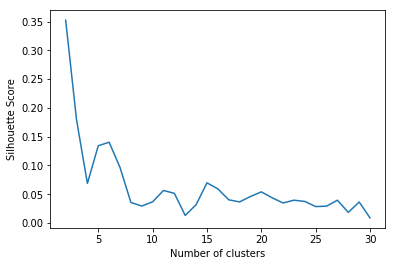

In [126]:
def sc_evaluate_clusters(X,max_clusters):
    s = np.zeros(max_clusters+1)
    s[0] = 0;
    s[1] = 0;
    for k in range(2,max_clusters+1):
        gmm = GaussianMixture(n_components=k,random_state=42).fit(reducedDf)
        preds = gmm.predict(reducedDf)
        s[k] = silhouette_score(X,preds,metric='euclidean')
    plt.plot(range(2,len(s)),s[2:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    
sc_evaluate_clusters(reducedDf,30)

We can see the second maxima i.e highest silhouette score value is when number of clusters is around 7.

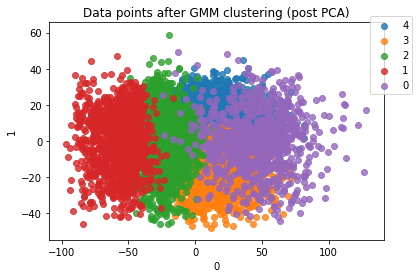

In [155]:
gmm = GaussianMixture(n_components=5,random_state=0).fit(reducedDf)
prediction = gmm.predict(reducedDf)
plotClasses2D(reducedDf,prediction,dimensionality_reduction='PCA',title='Data points after GMM clustering (post PCA)')

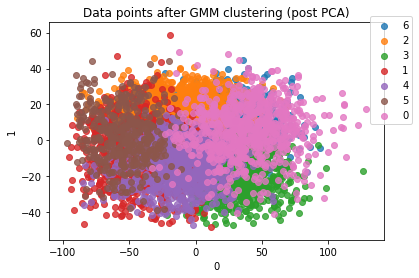

In [154]:
gmm = GaussianMixture(n_components=7,random_state=0).fit(reducedDf)
prediction = gmm.predict(reducedDf)
plotClasses2D(reducedDf,prediction,dimensionality_reduction='PCA',title='Data points after GMM clustering (post PCA)')

array([6, 6, 2, ..., 4, 3, 4], dtype=int64)